<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session12/EVA4S12_assignmentA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mounting Drive***

<hr>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import sys, os
!pip install scipy==1.1.0
print(sys.path)

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/'
path_models = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/models/'
sys.path.append(path)
sys.path.append(path_models)

***Loading the python files from drive***


In [4]:
# !pip install torch-lr-finder
!pip install -U albumentations
from imports_eva import *
import data_loaders as dl                         # Loading CIFAR10 data into train/test dataloaders
import resnet_18 as mfile                        # ResNet18 Model architecture
import train_test_functions as ttfunc             # Model training and validation functions
import test_performance as tperform               # Class wise model accuracy and confusion matrix plot
import model_plots as mp                          # Plotting the Train/Test plots for loss and accuracy
import resnet_modified_A11 as mdl
import misclassified                              # Display misclassified images by the trained model
from scheduler import *
from cyclic_lr import *

     |████████████████████████████████| 122kB 6.8MB/s 
     |████████████████████████████████| 634kB 34.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=ce0a91040082a4968f461b7d944411b1e194fd7ffa60e694e03994bb6a709bee
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=11199ea10482be5f5537628fe588a90ea693469c7ca83aa842a209beb82cd649
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


***Downloading the tiny image net dataset***

In [5]:
import os
import zipfile
import requests
from io import StringIO,BytesIO
def download_images(url):

    if (os.path.isdir("tiny-imagenet-200.zip")):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
download_images("http://cs231n.stanford.edu/tiny-imagenet-200.zip")
# download_images("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")

***Loading the dataset into numpy arrays and shuffling***

In [6]:
import time
import scipy.ndimage as nd
import numpy as np
import imageio

path = '/content/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [nd.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(nd.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels,test_labels))

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.seed(42)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]
  
data, labels = shuffle_data(data, labels)

print(data.shape, labels.shape)

labels = np.argmax(labels, axis=1)

print(data.shape, labels.shape)

starting loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


finished loading data, in 34.98989677429199 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)
(110000, 64, 64, 3) (110000, 200)
(110000, 64, 64, 3) (110000,)


In [0]:
# print(type(train_data))

In [0]:
# data = np.rollaxis(data, 3, 1) 
# data.shape, labels.shape

In [0]:
# plt.imshow(np.transpose(data[12345],( 1,2,0)))
# plt.show()
# labels[12345]

# img =torch.from_numpy(data[12345])
# img.shape
# plt.imshow(img)
# plt.show()

***Creating test/train loaders with augumentations***

In [7]:
trainloader, testloader = dl.train_test_loaders(train_dt = data[0:77000, :], train_lbls = labels[0:77000], test_dt = data[77000:, :], test_lbls = labels[77000:])

Training Data Shape:(77000, 64, 64, 3)
Training Label Shape:(77000,)
Training Data Shape:(33000, 64, 64, 3)
Training Label Shape:(33000,)


In [8]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.figure(figsize=(28,18))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # images.shape

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([256, 3, 64, 64])
torch.Size([256])


In [0]:
# images[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

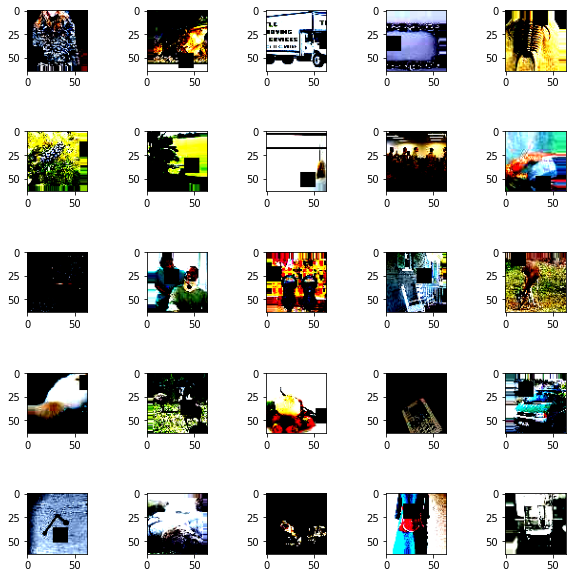

In [10]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     # npimg = img.numpy()
#     plt.figure(figsize=(28,18))
#     plt.imshow(img)
# imshow(torchvision.utils.make_grid(images))


figure = plt.figure(figsize=(10, 10))
figure.subplots_adjust(hspace=1, wspace=0.5)
for i in range(25):
    im = images[i]
    #im = im.numpy()
                 
    #lab = labels[i]
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(im, (1,2,0)))
    #plt.title("Label: %s" % labels[0])

plt.show()

# plt.imshow(images[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 3, 64, 64])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

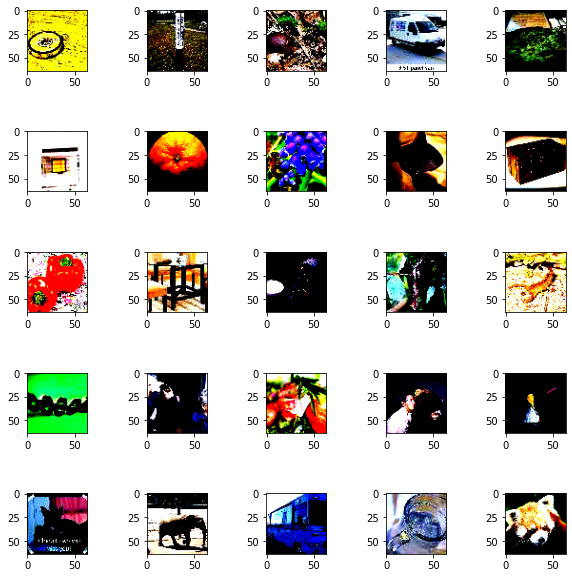

In [11]:
dataiter_test = iter(testloader)
images, labels = dataiter_test.next()

print(images.shape)
print(labels.shape)

# images[0].shape
# plt.imshow(images[0])
# plt.show()

figure = plt.figure(figsize=(10, 10))
figure.subplots_adjust(hspace=1, wspace=0.5)
for i in range(25):
    im = images[i]
    #im = im.numpy()
                 
    #lab = labels[i]
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(im, (1,2,0)))
    #plt.title("Label: %s" % labels[0])

plt.show()

***Load Resnet_18 model and print summary***

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# model = mdl.resnet_modified_A11().to(device)
model = mfile.resnet18(n = 200).to(device)
# model = resnet18(200).to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         Dropout2d-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         Dropout2d-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,864
       BatchNorm2d-8           [-1, 64, 64, 64]             128
         Dropout2d-9           [-1, 64, 64, 64]               0
       BasicBlock-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        Dropout2d-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1

***Creating schedules for LR and Momentum***
<hr>

In [0]:
max_lr = 0.105
min_lr = max_lr/10

In [14]:
lr_s = np.interp(np.arange(50), [0, 9, 39, 50], [min_lr, max_lr, min_lr, 0])
mtm_s = np.interp(np.arange(50), [0, 9, 39, 50], [0.95, 0.8, 0.95, 0.95])

print(lr_s)
print(mtm_s)

[0.0105     0.021      0.0315     0.042      0.0525     0.063
 0.0735     0.084      0.0945     0.105      0.10185    0.0987
 0.09555    0.0924     0.08925    0.0861     0.08295    0.0798
 0.07665    0.0735     0.07035    0.0672     0.06405    0.0609
 0.05775    0.0546     0.05145    0.0483     0.04515    0.042
 0.03885    0.0357     0.03255    0.0294     0.02625    0.0231
 0.01995    0.0168     0.01365    0.0105     0.00954545 0.00859091
 0.00763636 0.00668182 0.00572727 0.00477273 0.00381818 0.00286364
 0.00190909 0.00095455]
[0.95       0.93333333 0.91666667 0.9        0.88333333 0.86666667
 0.85       0.83333333 0.81666667 0.8        0.805      0.81
 0.815      0.82       0.825      0.83       0.835      0.84
 0.845      0.85       0.855      0.86       0.865      0.87
 0.875      0.88       0.885      0.89       0.895      0.9
 0.905      0.91       0.915      0.92       0.925      0.93
 0.935      0.94       0.945      0.95       0.95       0.95
 0.95       0.95       0.95       

***Model Training***
---
<hr>

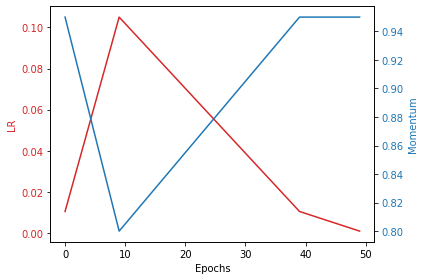

In [15]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LR', color=color)
ax1.plot(np.arange(50), lr_s, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Momentum', color=color)
ax2.plot(np.arange(50), mtm_s, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()


# plt.plot(np.arange(24),lr_s)
# plt.plot(np.arange(24),mtm_s)

In [39]:
classes = ()

from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
train_acc = []
train_loss = []
val_acc = []
val_loss = []


# model1 =  mdl.resnet_modified_A11().to(device)
model1 = mfile.resnet18(n = 200).to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum = 0.9, weight_decay=0.001)
scheduler1 = ListScheduler(optimizer1, lrs=lr_s, momentums=mtm_s)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer1.param_groups]
    current_m = [g['momentum'] for g in optimizer1.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    tr_ac_batch, tr_ls_batch, tr_ac_epoch, tr_ls_epoch   =  ttfunc.train(model1, device, trainloader, optimizer1, epoch)
    ts_ac, ts_ls =  ttfunc.test(model1, device, testloader, classes)
    scheduler1.step()
    print('')


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.010499999999999999], M : [0.9500000000000001]


Loss=4.011697769165039 Batch_id=300 Accuracy=6.92: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 3039/33000 (9.21%)


EPOCH: 2
LR: [0.020999999999999998], M : [0.9333333333333333]


Loss=3.6050870418548584 Batch_id=300 Accuracy=14.79: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 4550/33000 (13.79%)


EPOCH: 3
LR: [0.0315], M : [0.9166666666666665]


Loss=3.206441640853882 Batch_id=300 Accuracy=20.93: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 7287/33000 (22.08%)


EPOCH: 4
LR: [0.041999999999999996], M : [0.9]


Loss=3.4332873821258545 Batch_id=300 Accuracy=26.00: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 7373/33000 (22.34%)


EPOCH: 5
LR: [0.052500000000000005], M : [0.8833333333333333]


Loss=3.1355698108673096 Batch_id=300 Accuracy=30.02: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 7663/33000 (23.22%)


EPOCH: 6
LR: [0.063], M : [0.8666666666666667]


Loss=2.6610660552978516 Batch_id=300 Accuracy=33.20: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 9700/33000 (29.39%)


EPOCH: 7
LR: [0.0735], M : [0.85]


Loss=2.572067975997925 Batch_id=300 Accuracy=36.04: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 10586/33000 (32.08%)


EPOCH: 8
LR: [0.084], M : [0.8333333333333334]


Loss=2.3879714012145996 Batch_id=300 Accuracy=38.46: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 10301/33000 (31.22%)


EPOCH: 9
LR: [0.0945], M : [0.8166666666666667]


Loss=2.46943736076355 Batch_id=300 Accuracy=40.96: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 10942/33000 (33.16%)


EPOCH: 10
LR: [0.10499999999999998], M : [0.8]


Loss=2.113075017929077 Batch_id=300 Accuracy=43.02: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 11751/33000 (35.61%)


EPOCH: 11
LR: [0.10185], M : [0.805]


Loss=2.024372100830078 Batch_id=300 Accuracy=44.86: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11242/33000 (34.07%)


EPOCH: 12
LR: [0.0987], M : [0.81]


Loss=2.1989073753356934 Batch_id=300 Accuracy=46.17: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 12662/33000 (38.37%)


EPOCH: 13
LR: [0.09555], M : [0.8150000000000001]


Loss=2.195202589035034 Batch_id=300 Accuracy=47.57: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 13038/33000 (39.51%)


EPOCH: 14
LR: [0.0924], M : [0.8200000000000001]


Loss=2.280269145965576 Batch_id=300 Accuracy=48.83: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 12126/33000 (36.75%)


EPOCH: 15
LR: [0.08925], M : [0.8250000000000001]


Loss=2.0309832096099854 Batch_id=300 Accuracy=49.79: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 12044/33000 (36.50%)


EPOCH: 16
LR: [0.0861], M : [0.8300000000000001]


Loss=1.9973206520080566 Batch_id=300 Accuracy=50.95: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 12299/33000 (37.27%)


EPOCH: 17
LR: [0.08295], M : [0.835]


Loss=1.9708071947097778 Batch_id=300 Accuracy=51.96: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 10105/33000 (30.62%)


EPOCH: 18
LR: [0.0798], M : [0.84]


Loss=2.195077896118164 Batch_id=300 Accuracy=52.92: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 12993/33000 (39.37%)


EPOCH: 19
LR: [0.07665], M : [0.845]


Loss=1.8594412803649902 Batch_id=300 Accuracy=53.94: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 14661/33000 (44.43%)


EPOCH: 20
LR: [0.0735], M : [0.85]


Loss=1.7533023357391357 Batch_id=300 Accuracy=54.46: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 13643/33000 (41.34%)


EPOCH: 21
LR: [0.07035], M : [0.855]


Loss=1.7709016799926758 Batch_id=300 Accuracy=55.36: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 14220/33000 (43.09%)


EPOCH: 22
LR: [0.0672], M : [0.86]


Loss=1.6704208850860596 Batch_id=300 Accuracy=56.05: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 14495/33000 (43.92%)


EPOCH: 23
LR: [0.06405], M : [0.865]


Loss=1.6938008069992065 Batch_id=300 Accuracy=57.15: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 13784/33000 (41.77%)


EPOCH: 24
LR: [0.06089999999999999], M : [0.87]


Loss=1.8499118089675903 Batch_id=300 Accuracy=57.66: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 14004/33000 (42.44%)


EPOCH: 25
LR: [0.057749999999999996], M : [0.875]


Loss=1.8683404922485352 Batch_id=300 Accuracy=58.06: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 14089/33000 (42.69%)


EPOCH: 26
LR: [0.054599999999999996], M : [0.88]


Loss=1.5838534832000732 Batch_id=300 Accuracy=59.22: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 13973/33000 (42.34%)


EPOCH: 27
LR: [0.051449999999999996], M : [0.885]


Loss=1.647720217704773 Batch_id=300 Accuracy=59.78: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 14134/33000 (42.83%)


EPOCH: 28
LR: [0.048299999999999996], M : [0.89]


Loss=1.4746153354644775 Batch_id=300 Accuracy=60.64: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 15733/33000 (47.68%)


EPOCH: 29
LR: [0.045149999999999996], M : [0.895]


Loss=1.6321007013320923 Batch_id=300 Accuracy=60.95: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 15303/33000 (46.37%)


EPOCH: 30
LR: [0.041999999999999996], M : [0.9]


Loss=1.3705068826675415 Batch_id=300 Accuracy=62.02: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15441/33000 (46.79%)


EPOCH: 31
LR: [0.038849999999999996], M : [0.905]


Loss=1.6669427156448364 Batch_id=300 Accuracy=62.94: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 15019/33000 (45.51%)


EPOCH: 32
LR: [0.035699999999999996], M : [0.91]


Loss=1.269659399986267 Batch_id=300 Accuracy=63.70: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16140/33000 (48.91%)


EPOCH: 33
LR: [0.032549999999999996], M : [0.9149999999999999]


Loss=1.215968370437622 Batch_id=300 Accuracy=65.05: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 15378/33000 (46.60%)


EPOCH: 34
LR: [0.029399999999999996], M : [0.9199999999999999]


Loss=1.320934772491455 Batch_id=300 Accuracy=65.65: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15764/33000 (47.77%)


EPOCH: 35
LR: [0.026249999999999996], M : [0.9249999999999999]


Loss=1.5038249492645264 Batch_id=300 Accuracy=67.11: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 16563/33000 (50.19%)


EPOCH: 36
LR: [0.023099999999999996], M : [0.9299999999999999]


Loss=1.2713158130645752 Batch_id=300 Accuracy=68.29: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 16223/33000 (49.16%)


EPOCH: 37
LR: [0.019949999999999996], M : [0.9349999999999999]


Loss=1.3305259943008423 Batch_id=300 Accuracy=70.00: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 17080/33000 (51.76%)


EPOCH: 38
LR: [0.016799999999999995], M : [0.9399999999999998]


Loss=1.257417917251587 Batch_id=300 Accuracy=72.00: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 17685/33000 (53.59%)


EPOCH: 39
LR: [0.013649999999999995], M : [0.9449999999999998]


Loss=1.133540153503418 Batch_id=300 Accuracy=74.54: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 17876/33000 (54.17%)


EPOCH: 40
LR: [0.010499999999999999], M : [0.9500000000000001]


Loss=1.1122924089431763 Batch_id=300 Accuracy=77.66: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 17885/33000 (54.20%)


EPOCH: 41
LR: [0.009545454545454544], M : [0.9500000000000001]


Loss=0.8537760376930237 Batch_id=300 Accuracy=80.07: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 17925/33000 (54.32%)


EPOCH: 42
LR: [0.00859090909090909], M : [0.9500000000000001]


Loss=0.7503109574317932 Batch_id=300 Accuracy=82.09: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 18257/33000 (55.32%)


EPOCH: 43
LR: [0.007636363636363636], M : [0.9500000000000001]


Loss=0.6849406957626343 Batch_id=300 Accuracy=84.36: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 18659/33000 (56.54%)


EPOCH: 44
LR: [0.006681818181818181], M : [0.9500000000000001]


Loss=0.49236124753952026 Batch_id=300 Accuracy=86.99: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 18931/33000 (57.37%)


EPOCH: 45
LR: [0.005727272727272727], M : [0.9500000000000001]


Loss=0.6133456230163574 Batch_id=300 Accuracy=89.68: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 19240/33000 (58.30%)


EPOCH: 46
LR: [0.004772727272727272], M : [0.9500000000000001]


Loss=0.44133761525154114 Batch_id=300 Accuracy=91.91: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 19632/33000 (59.49%)


EPOCH: 47
LR: [0.003818181818181818], M : [0.9500000000000001]


Loss=0.3376089930534363 Batch_id=300 Accuracy=94.43: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 20088/33000 (60.87%)


EPOCH: 48
LR: [0.0028636363636363633], M : [0.9500000000000001]


Loss=0.26322081685066223 Batch_id=300 Accuracy=96.34: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 20334/33000 (61.62%)


EPOCH: 49
LR: [0.001909090909090909], M : [0.9500000000000001]


Loss=0.18843168020248413 Batch_id=300 Accuracy=97.60: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 20519/33000 (62.18%)


EPOCH: 50
LR: [0.0009545454545454544], M : [0.9500000000000001]


Loss=0.17888356745243073 Batch_id=300 Accuracy=98.37: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]



Test set: Average loss: 0.0063, Accuracy: 20659/33000 (62.60%)


